In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
import shapely.geometry
import shapely.ops as so

In [2]:
# Position
x0 = 0
xf = 30
xobs = [[5, 7], [10, 11], [15, 16], [23, 25]]
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
K = 1000
iter_max = 1000
tMax = 20
vmax = 5

In [3]:
# Obstacle Setting
# [start, close, open]
obs1 = [0, 2.5, 2.5]
obs2 = [0, 4, 4]
obs3 = [0, 3, 3]
obs4 = [0, 8, 2.5]
obs_vec = [obs1, obs2, obs3, obs4]

In [4]:
def distance(a, b):
    return b - a

In [5]:
def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [6]:
def reachable_RRTC(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    
    if dx == 0:
        return True
    else:
        if forward and np.abs(dx/dt) <= vmax and dt > 0:
            return True
        elif not forward and np.abs(dx/dt) <= vmax and dt < 0:
            return True
        return False

In [7]:
def random_sample_RRTC(tf, n, k):
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal and n == 1:
        # IF not, sample goal
        if np.mod(k, 2) == 0: # Start from bottom tree (x0)
            xrand = xf
            trand = tf
        else:                 # Start from top tree (xf)
            xrand = x0
            trand = 0
    elif not sample_goal or n >= 1:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        if n == 1:
            xrand = rand_points[0][0]
            trand = rand_points[0][1]
            return [xrand, trand]
        else:
            return rand_points
    return [xrand, trand]

In [8]:
def extend(qclosest, q1):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    norm = np.sqrt(dx**2 + dt**2)
    dxnorm = dx/norm*vmax
    dtnorm = dt/norm*vmax
    qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

In [9]:
def find_neighbor_RRTC(qrand, V, k):
    # Find neighbor
    dist_vec = []
    if np.mod(k,2) == 0:
        forward = True
    else:
        forward = False

    for i in range(len(V)):
        if reachable_RRTC(V[i], qrand, forward):
            dist_vec.append(distance(V[i][0], qrand[0]))

    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [10]:
def check_route_test(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [11]:
def find_path_test(vi, vf, V, E, trigger):
    # trigger:
    # 0 -> a
    # 1 -> b
    path_vec = []
    path_vec.append(vf)
    curr = vf
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                if trigger == 0:
                    curr = E[ei][0]
                else:
                    curr = E[ei][0]
                path_vec.append(curr)
                break
        kek += 1

        if trigger == 0:
            if curr[0] == vi[0] and curr[1] == vi[1]:
                return path_vec
        elif trigger == 1:
            if np.abs(curr[0]-vi[0]) <= 0.1:
                return path_vec
            

In [12]:
# Standard ST-RRT-Connect
RRTC_total_time = []
RRTC_total_distance = []
time_vec_RRTC = []
iter = 0
success_RRTC = 0
tf = 30
while iter < iter_max:
    print('iter: ', iter)
    start = time.time()
    t_test = []
    V_RRTConnect = {}
    E_RRTConnect = {}
    kk = 0
    while 1:
        tmax = tf
        # print('tf: ', tf)
        k = 0
        V_RRTCa = []
        V_RRTCa.append([x0, 0])
        V_RRTCb = []
        V_RRTCb.append([xf, tf])
        V_RRTCb_raw = []

        T_RRTCa = []
        T_RRTCb = []
        T_RRTCa.append(0)
        T_RRTCa.append(tf)

        E_RRTCa = []
        E_RRTCb = []

        while k < K:
            t_check = []
            # print('k: ', k)
            while 1:
                # Sample
                sample_start = time.time()
                qrand = random_sample_RRTC(tf, 1, k)
                # print('sample time: ', time.time()-sample_start)
                t_check.append(time.time()-sample_start)

                neighbor_start = time.time()
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
                # print('neighbor check time: ', time.time()-neighbor_start)
                t_check.append(time.time()-neighbor_start)
                
                if qclosest is not None:
                    extend_start = time.time()
                    qnew = extend(qclosest, qrand)
                    # print('extend time: ', time.time()-extend_start)
                    t_check.append(time.time()-extend_start)
                        
                    # Validate
                    validate_start = time.time()
                    check_vec = validate(qnew)
                    # print('validation time: ', time.time()-validate_start)
                    t_check.append(time.time()-validate_start)
                    if np.sum(check_vec) == 0:
                        check_route_start = time.time()
                        kek = check_route_test(qclosest, qnew, tf)
                        # print('route_check: ', time.time()-check_route_start)
                        t_check.append(time.time()-check_route_start)
                        # print('total: ', time.time()-sample_start)
                        if kek:
                            break
                
            # Add V, E
            add_start = time.time()
            if np.mod(k, 2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
            else:
                V_RRTCb.append(qnew)
                E_RRTCb.append([qclosest, qnew])
                T_RRTCb.append(qnew[1])
                V_RRTCb_raw.append(qrand)
            # print('Add time: ', time.time()-add_start)
            t_check.append(time.time()-add_start)

            # Check continue
            path_check_start = time.time()
            path_check = False
            if np.mod(k,2) == 0:
                for vj in V_RRTCb:
                    if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                        if check_route_test(V_RRTCa[-1], vj, tf) and reachable_RRTC(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            success_RRTC += 1
                            break
            else:
                for vi in V_RRTCa:
                    if reachable_RRTC(vi, V_RRTCb[-1], forward=False):
                        if check_route_test(vi, V_RRTCb[-1], tf) and reachable_RRTC(vi, V_RRTCb[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb[-1]]
                            path_check = True
                            success_RRTC += 1
                            break
            # print('path_check: ', time.time()-path_check_start)
            t_check.append(time.time()-path_check_start)
            # print('total from sample: ', time.time()-sample_start)
            t_test.append(time.time()-sample_start)
            k += 1

            if path_check:
                # print('Path Found')
                path_start = time.time()
                E_RRTC = E_RRTCa + E_RRTCb
                E_RRTC.append(connect_edge)
                patha_start = time.time()
                patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
                # print('Path a: ', time.time()-patha_start)
                pathb_start = time.time()
                pathb = find_path_test([xf, tf], E_RRTC[-1][1], V_RRTCb, E_RRTCb, 1)
                # print('Path b: ', time.time()-pathb_start)
                final_path = list(reversed(patha)) + pathb
                # print('path compute: ', time.time()-path_start)
                total_path_time = 0
                total_path_distance = 0
                for fpv in final_path:
                    total_path_time += fpv[1]
                    total_path_distance += fpv[0]
                RRTC_total_time.append(total_path_time)
                RRTC_total_distance.append(total_path_distance)
                break
        V_RRTConnect[str(kk)] = [V_RRTCa, V_RRTCb]
        E_RRTConnect[str(kk)] = [E_RRTCa, E_RRTCb]

        # print('Path_check: ', path_check)
        if tf >= 50 or path_check:
            # print('end')
            break
        tf += 5
        kk += 1

    end = time.time()
    # print('final time: ', end-start)
    
    time_vec_RRTC.append(end-start)
    iter += 1


print('Average Computation Time (sec): ', sum(time_vec_RRTC)/len(time_vec_RRTC))
print('Average Path Time (sec): ', sum(RRTC_total_time)/len(RRTC_total_time))
print('Average Path Distance (sec): ', sum(RRTC_total_distance)/len(RRTC_total_distance))
print('Success Rate: ', success_RRTC/iter_max)

iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19
iter:  20
iter:  21
iter:  22
iter:  23
iter:  24
iter:  25
iter:  26
iter:  27
iter:  28
iter:  29
iter:  30
iter:  31
iter:  32
iter:  33
iter:  34
iter:  35
iter:  36
iter:  37
iter:  38
iter:  39
iter:  40
iter:  41
iter:  42
iter:  43
iter:  44
iter:  45
iter:  46
iter:  47
iter:  48
iter:  49
iter:  50
iter:  51
iter:  52
iter:  53
iter:  54
iter:  55
iter:  56
iter:  57
iter:  58
iter:  59
iter:  60
iter:  61
iter:  62
iter:  63
iter:  64
iter:  65
iter:  66
iter:  67
iter:  68
iter:  69
iter:  70
iter:  71
iter:  72
iter:  73
iter:  74
iter:  75
iter:  76
iter:  77
iter:  78
iter:  79
iter:  80
iter:  81
iter:  82
iter:  83
iter:  84
iter:  85
iter:  86
iter:  87
iter:  88
iter:  89
iter:  90
iter:  91
iter:  92
iter:  93
iter:  94
iter:  95
iter:  96
iter:  97
iter:  98
iter:  99
iter:  100

In [13]:
# fig = plt.figure()
# xvec = np.linspace(0, len(t_test)-1, len(t_test))
# plt.plot(xvec, t_test, '-r')
# plt.plot([0, len(xvec)], [0.05, 0.05])
# print(np.sum(t_test))

# legend_vec = ['sample', 'neighbor', 'extend', 'validate', 'check_route', 'add route', 'path_check', '']
# fig = plt.figure()
# xvec = np.linspace(0, len(t_check)-1, len(t_check))
# for i in range(len(legend_vec)):
#     plt.plot(xvec[i], t_check[i], 'or')
#     plt.text(xvec[i], t_check[i]+min(t_check), legend_vec[i])
# print(np.sum(t_check))

Text(0, 0.5, 't')

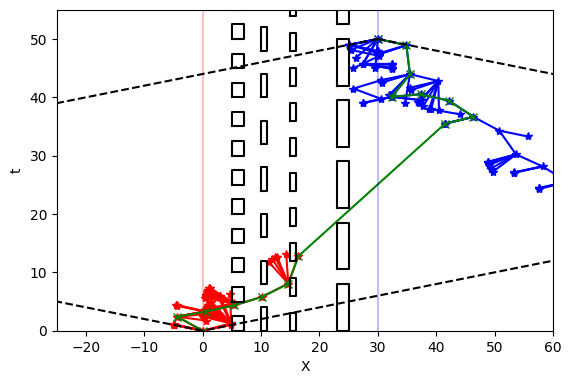

In [14]:
fig = plt.figure()
ax = fig.subplots()
# RRTConnect
for rrtv in V_RRTCa:
   plt.plot(rrtv[0], rrtv[1], 'r*')
for rrtv in V_RRTCb:
   plt.plot(rrtv[0], rrtv[1], 'b*')
# for rrtvr in V_RRTCb_raw:
#     plt.plot(rrtvr[0], rrtvr[1], 'm.')
for rrte in E_RRTCa:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)
for rrte in E_RRTCb:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-')#, alpha=0.25)
if final_path is not None:
    for pathi in final_path:
        plt.plot(pathi[0], pathi[1], 'gx')
    for ii in range(len(final_path)-1):
        plt.plot([final_path[ii][0], final_path[ii+1][0]], [final_path[ii][1], final_path[ii+1][1]], '-g')


# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf, tf, 'xb', alpha=0.5)
plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf, tf]
point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
# plt.xlim(point3[0]-5, point4[0]+5)
plt.xlim(-25, 60)
plt.ylim(0, tf+5)
plt.xlabel('X')
plt.ylabel('t')

Text(0, 0.5, 't (sec)')

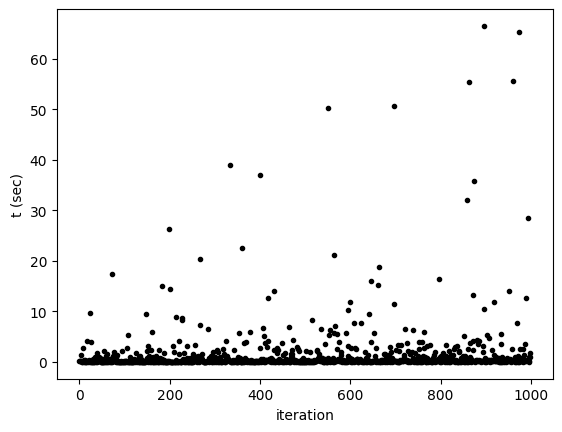

In [15]:
fig = plt.figure()
xaxis = np.linspace(0, len(time_vec_RRTC)-1, len(time_vec_RRTC))
plt.plot(xaxis, time_vec_RRTC, '.k')
plt.xlabel('iteration')
plt.ylabel('t (sec)')

ST-RRT-Connect with Time-Shadow

In [16]:
"""ST-RRT with Time Shadow"""
def isInside(A, B, C, x, y):
    # Decomposition
    x1 = A[0]
    y1 = A[1]
    x2 = B[0]
    y2 = B[1]
    x3 = C[0]
    y3 = C[1]

    c1 = (x2-x1)*(y-y1)-(y2-y1)*(x-x1)
    c2 = (x3-x2)*(y-y2)-(y3-y2)*(x-x2)
    c3 = (x1-x3)*(y-y3)-(y1-y3)*(x-x3)
    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        # In Triangle
        return True
    else:
        # Not in Triangle
        return False
    
def obstacle_check_timeshadow(q2, obs_pos, obs_t, forward= True):
    trand = q2[1]
    temp = trand - obs_t[0]
    tempt = np.mod(temp, obs_t[1]+obs_t[2])

    if tempt >= obs_t[1] and tempt <= (obs_t[1]+obs_t[2]):
        if forward:
            # Not Caught
            X1 = [obs_pos[0], obs_t[1]+obs_t[2]]
            X2 = [obs_pos[1], obs_t[1]+obs_t[2]]
            X3 = [obs_pos[0]+(obs_pos[1]-obs_pos[0])/2, (obs_pos[0]+(obs_pos[1]-obs_pos[0])/2)/vmax + (X2[1]-X2[0]/vmax)]
        else:
            X1 = [obs_pos[0], obs_t[1]]
            X2 = [obs_pos[1], obs_t[1]]
            X3 = [obs_pos[0]+(obs_pos[1]-obs_pos[0])/2, (obs_pos[0]+(obs_pos[1]-obs_pos[0])/2)/vmax + (X1[1]-X1[0]/vmax)]

        if isInside(X1, X2, X3, q2[0], tempt):
            # Caught
            return False
        else:
            return True
    else:
        # Caught
        return False 
    
def validate_timeshadow(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if np.mod(k,2) == 0:
                if obstacle_check(q2[1], obs_vec[i]) and obstacle_check_timeshadow(q2, xobs[i], obs_vec[i], True):
                    check_vec.append(0)
                else:
                    check_vec.append(1)
            else:
                if obstacle_check(q2[1], obs_vec[i]) and obstacle_check_timeshadow(q2, xobs[i], obs_vec[i], False):
                    check_vec.append(0)
                else:
                    check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

In [17]:
def time_block_obstacle_timeshadow(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]
    timeblock = shapely.geometry.Polygon([point1, point2, point3, point4])

    # Downward Triangle
    X1 = [pos_obs[0], time_obs[0]+time_obs[1]+time_obs[2]+time_translate]
    X2 = [pos_obs[1], time_obs[0]+time_obs[1]+time_obs[2]+time_translate]
    X3 = [pos_obs[0]+(pos_obs[1]-pos_obs[0])/2, (pos_obs[0]+(pos_obs[1]-pos_obs[0])/2)/vmax + (X2[1]-X2[0]/vmax)]
    downTriangle = shapely.geometry.Polygon([X1, X2, X3])

    # Upward Triangle
    X4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]
    X5 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    X6 = [pos_obs[0]+(pos_obs[1]-pos_obs[0])/2, (pos_obs[0]+(pos_obs[1]-pos_obs[0])/2)/vmax + (X4[1]-X4[0]/vmax)]
    upperTriangle = shapely.geometry.Polygon([X4, X5, X6])

    return so.unary_union([timeblock, downTriangle, upperTriangle])

In [18]:
def check_route_test_timeshadow(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle_timeshadow(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [23]:
# Standard ST-RRT-Connect with Timeshadow
RRT_RS_total_time = []
RRT_RS_total_distance = []
time_vec_RRTC_TS = []
iter = 0
iter_max = 100
success_RRTC_TS = 0
tf = 30
while iter < iter_max:
    print('iter: ', iter)
    start = time.time()
    t_test = []
    V_RRTConnect_TS = {}
    E_RRTConnect_TS = {}
    kk = 0
    while 1:
        tmax = tf
        # print('tf: ', tf)
        k = 0
        V_RRTCa_TS = []
        V_RRTCa_TS.append([x0, 0])
        V_RRTCa_TS_raw = []
        V_RRTCb_TS = []
        V_RRTCb_TS.append([xf, tf])
        V_RRTCb_TS_raw = []

        T_RRTCa_TS = []
        T_RRTCb_TS = []
        T_RRTCa_TS.append(0)
        T_RRTCa_TS.append(tf)

        E_RRTCa_TS = []
        E_RRTCb_TS = []

        while k < K:
            t_check = []
            # print('k: ', k)
            while 1:
                # Sample
                sample_start = time.time()
                qrand = random_sample_RRTC(tf, 1, k)
                # print('sample time: ', time.time()-sample_start)
                t_check.append(time.time()-sample_start)

                neighbor_start = time.time()
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa_TS, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb_TS, k)
                # print('neighbor check time: ', time.time()-neighbor_start)
                t_check.append(time.time()-neighbor_start)
                
                if qclosest is not None:
                    extend_start = time.time()
                    qnew = extend(qclosest, qrand)
                    # print('extend time: ', time.time()-extend_start)
                    t_check.append(time.time()-extend_start)
                        
                    # Validate
                    validate_start = time.time()
                    check_vec = validate_timeshadow(qnew)
                    # print('validation time: ', time.time()-validate_start)
                    t_check.append(time.time()-validate_start)
                    if np.sum(check_vec) == 0:
                        check_route_start = time.time()
                        kek = check_route_test_timeshadow(qclosest, qnew, tf)
                        # print('route_check: ', time.time()-check_route_start)
                        t_check.append(time.time()-check_route_start)
                        # print('total: ', time.time()-sample_start)
                        if kek:
                            break
                
            # Add V, E
            add_start = time.time()
            if np.mod(k, 2) == 0:
                V_RRTCa_TS_raw.append(qrand)
                V_RRTCa_TS.append(qnew)
                E_RRTCa_TS.append([qclosest, qnew])
                T_RRTCa_TS.append(qnew[1])
            else:
                V_RRTCb_TS_raw.append(qrand)
                V_RRTCb_TS.append(qnew)
                E_RRTCb_TS.append([qclosest, qnew])
                T_RRTCb_TS.append(qnew[1])
            # print('Add time: ', time.time()-add_start)
            t_check.append(time.time()-add_start)

            # Check continue
            path_check_start = time.time()
            path_check = False
            if np.mod(k,2) == 0:
                for vj in V_RRTCb_TS:
                    if reachable_RRTC(V_RRTCa_TS[-1], vj, forward=True):
                        if check_route_test_timeshadow(V_RRTCa_TS[-1], vj, tf) and reachable_RRTC(V_RRTCa_TS[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa_TS[-1], vj]
                            path_check = True
                            success_RRTC_TS += 1
                            break
            else:
                for vi in V_RRTCa_TS:
                    if reachable_RRTC(vi, V_RRTCb_TS[-1], forward=False):
                        if check_route_test_timeshadow(vi, V_RRTCb_TS[-1], tf) and reachable_RRTC(vi, V_RRTCb_TS[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb_TS[-1]]
                            path_check = True
                            success_RRTC_TS += 1
                            break
            # print('path_check: ', time.time()-path_check_start)
            t_check.append(time.time()-path_check_start)
            # print('total from sample: ', time.time()-sample_start)
            t_test.append(time.time()-sample_start)
            k += 1

            if path_check:
                # print('Path Found')
                path_start = time.time()
                E_RRTC_TS = E_RRTCa_TS + E_RRTCb_TS
                E_RRTC_TS.append(connect_edge)
                patha_start = time.time()
                patha = find_path_test([x0, 0], E_RRTC_TS[-1][0], V_RRTCa_TS, E_RRTCa_TS, 0)
                # print('Path a: ', time.time()-patha_start)
                pathb_start = time.time()
                pathb = find_path_test([xf, tf], E_RRTC_TS[-1][1], V_RRTCb_TS, E_RRTCb_TS, 1)
                # print('Path b: ', time.time()-pathb_start)
                final_path = list(reversed(patha)) + pathb
                # print('path compute: ', time.time()-path_start)
                total_path_time = 0
                total_path_distance = 0
                for fpv in final_path:
                    total_path_time += fpv[1]
                    total_path_distance += fpv[0]
                RRT_RS_total_time.append(total_path_time)
                RRT_RS_total_distance.append(total_path_distance)
                break
        V_RRTConnect_TS[str(kk)] = [V_RRTCa_TS, V_RRTCb_TS]
        E_RRTConnect_TS[str(kk)] = [E_RRTCa_TS, E_RRTCb_TS]

        # print('Path_check: ', path_check)
        if tf >= 50 or path_check:
            # print('end')
            break
        tf += 5
        kk += 1

    end = time.time()
    # print('final time: ', end-start)
    # if end-start >= 10:
    #     break
    
    time_vec_RRTC_TS.append(end-start)
    iter += 1


print('Average Computation Time (sec): ', sum(time_vec_RRTC_TS)/len(time_vec_RRTC_TS))
print('Average Path Time (sec): ', sum(RRT_RS_total_time)/len(RRT_RS_total_time))
print('Average Path Distance (sec): ', sum(RRT_RS_total_distance)/len(RRT_RS_total_distance))
print('Success Rate: ', success_RRTC_TS/iter_max)

iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19
iter:  20
iter:  21
iter:  22
iter:  23
iter:  24
iter:  25
iter:  26
iter:  27
iter:  28
iter:  29
iter:  30
iter:  31
iter:  32
iter:  33
iter:  34
iter:  35
iter:  36
iter:  37
iter:  38
iter:  39
iter:  40
iter:  41
iter:  42
iter:  43
iter:  44
iter:  45
iter:  46
iter:  47
iter:  48
iter:  49
iter:  50
iter:  51
iter:  52
iter:  53
iter:  54
iter:  55
iter:  56
iter:  57
iter:  58
iter:  59
iter:  60
iter:  61
iter:  62
iter:  63
iter:  64
iter:  65
iter:  66
iter:  67
iter:  68
iter:  69
iter:  70
iter:  71
iter:  72
iter:  73
iter:  74
iter:  75
iter:  76
iter:  77
iter:  78
iter:  79
iter:  80
iter:  81
iter:  82
iter:  83
iter:  84
iter:  85
iter:  86
iter:  87
iter:  88
iter:  89
iter:  90
iter:  91
iter:  92
iter:  93
iter:  94
iter:  95
iter:  96
iter:  97
iter:  98
iter:  99
Average Co

Text(0, 0.5, 't')

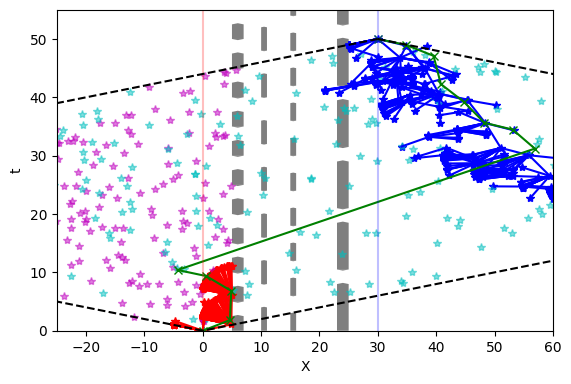

In [20]:
fig = plt.figure()
ax = fig.subplots()
# RRTConnect
for rrtv in V_RRTCa_TS:
   plt.plot(rrtv[0], rrtv[1], 'r*')
for rrtv in V_RRTCb_TS:
   plt.plot(rrtv[0], rrtv[1], 'b*')
for rrtv in V_RRTCa_TS_raw:
   plt.plot(rrtv[0], rrtv[1], 'm*', alpha=0.5)
for rrtv in V_RRTCb_TS_raw:
   plt.plot(rrtv[0], rrtv[1], 'c*', alpha=0.5)
for rrte in E_RRTCa_TS:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)
for rrte in E_RRTCb_TS:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-')#, alpha=0.25)
if final_path is not None:
    for pathi in final_path:
        plt.plot(pathi[0], pathi[1], 'gx')
    for ii in range(len(final_path)-1):
        plt.plot([final_path[ii][0], final_path[ii+1][0]], [final_path[ii][1], final_path[ii+1][1]], '-g')


# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    obs_pos = xobs[i]
    obs_t = obs_vec[i]
    for j in range(obs_number):
        this_obstacle = time_block_obstacle_timeshadow(obs_pos, obs_t, j)
        for geom in this_obstacle.geoms:    
            xs, ys = geom.exterior.xy
            plt.fill(xs, ys, alpha=.5, fc='k', ec='none')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf, tf, 'xb', alpha=0.5)
plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf, tf]
point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
# plt.xlim(point3[0]-5, point4[0]+5)
plt.xlim(-25, 60)
plt.ylim(0, tf+5)
plt.xlabel('X')
plt.ylabel('t')

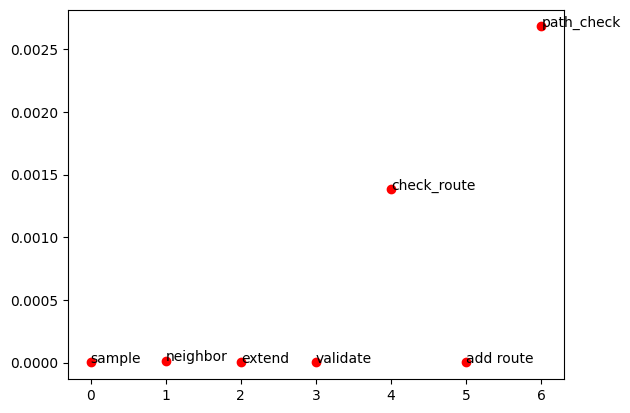

In [24]:
legend_vec = ['sample', 'neighbor', 'extend', 'validate', 'check_route', 'add route', 'path_check']
fig = plt.figure()
xvec = np.linspace(0, len(t_check)-1, len(t_check))
for i in range(len(legend_vec)):
    plt.plot(xvec[i], t_check[i], 'or')
    plt.text(xvec[i], t_check[i], legend_vec[i])

Text(0, 0.5, '')

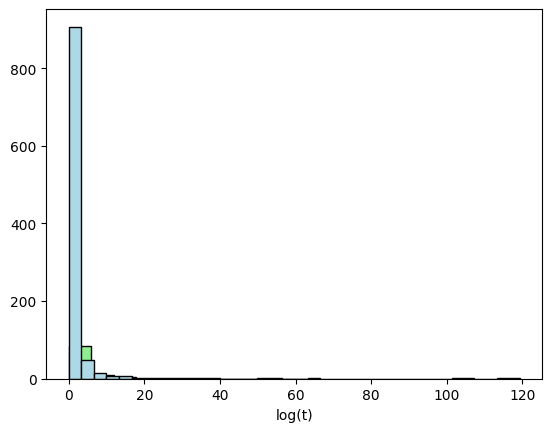

In [25]:
fig = plt.figure()
plt.hist(time_vec_RRTC_TS, color='lightgreen', ec='black', bins=20)
plt.hist(time_vec_RRTC, color='lightblue', ec='black', bins=20)
plt.xlabel('log(t)')
plt.ylabel('')

Average Computation Time (sec):  1.5900454839230063


Text(0, 0.5, 't (sec)')

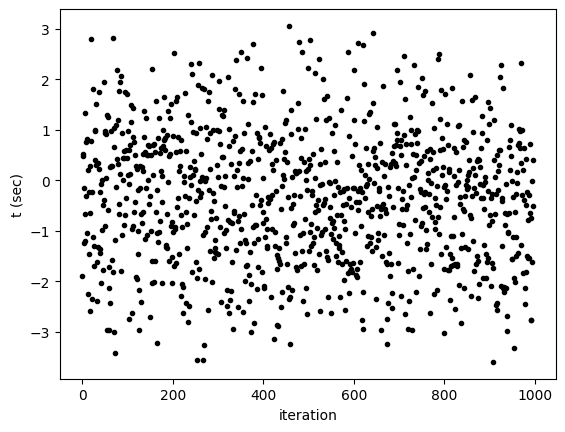

In [ ]:
fig = plt.figure()
xaxis = np.linspace(0, len(time_vec_RRTC_TS)-1, len(time_vec_RRTC_TS))
print('Average Computation Time (sec): ', sum(time_vec_RRTC_TS)/len(time_vec_RRTC_TS))
plt.plot(xaxis, np.log(time_vec_RRTC_TS), '.k')
plt.xlabel('iteration')
plt.ylabel('t (sec)')

Average Computation Time (sec):  1.5900454839230063


Text(0, 0.5, 't (sec)')

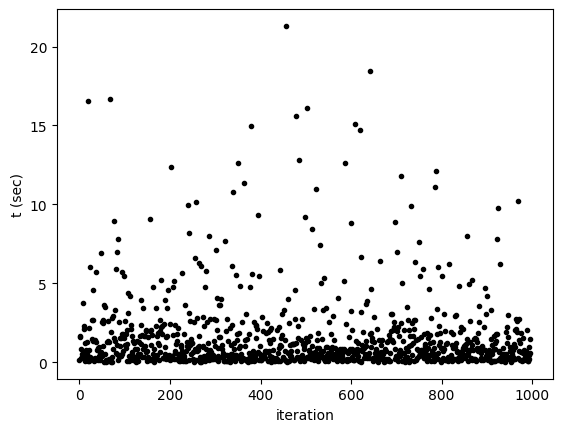

In [ ]:
fig = plt.figure()
xaxis = np.linspace(0, len(time_vec_RRTC_TS)-3, len(time_vec_RRTC_TS)-2)
time_vec_RRTC_TS_nooutlier = time_vec_RRTC_TS
time_vec_RRTC_TS_nooutlier.remove(max(time_vec_RRTC_TS))
time_vec_RRTC_TS_nooutlier.remove(max(time_vec_RRTC_TS_nooutlier))
print('Average Computation Time (sec): ', sum(time_vec_RRTC_TS_nooutlier)/len(time_vec_RRTC_TS_nooutlier))
plt.plot(xaxis, time_vec_RRTC_TS_nooutlier, '.k')
plt.xlabel('iteration')
plt.ylabel('t (sec)')